# CDK2 protein No CoCrys mols
# Data load and preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%run ../modules/run_or_load_decorator.py
%run ../modules/plotting_metrics.py

In [2]:
%run ./1_Helper_functions.ipynb

In [38]:
protein_name='cdk2_NO_CRYS'

file_name = '../6_Machine_Learning_Models/df_DkSc_results_COCRYS_CSAR_DEKOIS_DUD.pkl'
X_merged_dksc = pd.read_pickle(file_name)
y_true_merged = X_merged_dksc['activity']
X_merged_dksc = X_merged_dksc.drop('activity', axis=1)
X_merged_dksc.shape

#### Ommit cocrys mols ###############
query='library != "COCRYS"'

# Simplify the names
X = X_merged_dksc.query(query).values
y = y_true_merged.to_frame().query(query)['activity'].values
######################################

R_a = round(y.sum() / len(y), 2)
print('Ra =', R_a)

Ra = 0.04


## Estimators
### ML Classifiers

In [4]:
from sklearn.neighbors import KNeighborsClassifier

hyparams ={'n_neighbors': 1, 'n_jobs': 4}
knn = KNeighborsClassifier(**hyparams)

In [5]:
from sklearn.linear_model import LogisticRegression 

hyparams = {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter':400}
lr = LogisticRegression(**hyparams)

In [6]:
from xgboost import XGBClassifier

hyparams ={'subsample': 0.5, 'n_estimators': 200, 
           'max_depth': 20, 'learning_rate': 0.05, 
           'gamma': 0.01, 'colsample_bytree': 0.5, 'alpha': 0.01}
xgb = XGBClassifier(**hyparams)

In [7]:
# ML Classifier
ml_classifiers = {
    'knn': knn,
    'lr': lr,
    'xgb': xgb,
}

# update names
ml_classifiers = {f'ml_{name}': clf 
                for name, clf in ml_classifiers.items()}

### Consensus Scorings

In [8]:
%run ../6_Machine_Learning_Models/5_Helper_Consensus_Scoring.ipynb

cs_functions = {
    'MEAN': get_mean_score,
    'MAX': get_max_score,
    'MIN': get_min_score,
    'VOTE': get_vote_score
}

# update names
cs_functions = {f'cs_{name}': func 
                for name, func in cs_functions.items()}

### Estimators dictionary 

In [9]:
estimators = {**ml_classifiers, **cs_functions}

### Evaluation metrics 

In [10]:
metrics=dict(roc_auc = {'metric_name': 'roc_auc'},
             nef_02 = {'metric_name': 'ef', 
                    'fraction': 0.02, 'method':'normalized'},
             nef_01 = {'metric_name': 'ef', 
                    'fraction': 0.005, 'method':'normalized'},
             nef_Ra = {'metric_name': 'ef', 
                    'fraction': R_a, 'method':'normalized'}
            )

# Hold-out Validation 

### 30 replicas


In [11]:
# Save the results to a file to ommit repeate the analysis
@run_or_load_joblib
def n_hold_out_validation_SAVE(filename, **kwargs):
    return n_hold_out_validation(**kwargs)

In [12]:
%%time
evaluation_name='ho30'
ho30 = n_hold_out_validation_SAVE(
    filename=f'./cachedir/{evaluation_name}_{protein_name}',
    estimators=estimators, X=X, y=y, metrics=metrics, 
                      n_reps=30, random_state=42)

full_names = ['1-NN', 'Log. Reg.', 'XGB', 'csMAX', 'csMEAN', 'csMIN', 'csVOTE']
new_names = dict(zip(
    [*ho30.columns],
    full_names))

ho30 = ho30.rename(columns=new_names)

File saved: ./cachedir/ho30_cdk2_NO_CRYS
CPU times: user 10min 43s, sys: 46.4 s, total: 11min 29s
Wall time: 2min 7s


In [13]:
%run Friedman_and_Nemenyi_test.ipynb
%load_ext rpy2.ipython

## AUC-ROC

In [48]:
# ROC-AUC
metric_name='roc_auc'

# Normality
display(multi_norm_test(ho30, metric=metric_name))
# Homocedasticity
display(multi_homovar_test(ho30, metric=metric_name))

friedmanTest(ho30.loc[metric_name])

1-NN  Log. Reg.  XGB  csMAX  csMEAN  csMIN  csVOTE
Normality     1          1    1      1       1      1       1

statistic         p
Bartlett   8.503149  0.203508

chi^2  dof       p_value
Friedman Test  161.071429    6  3.511679e-32

In [49]:
df_R = order_df(ho30, metric_name).loc[metric_name]
df_Rmelted = pd.melt(df_R, var_name='method', value_name='score')

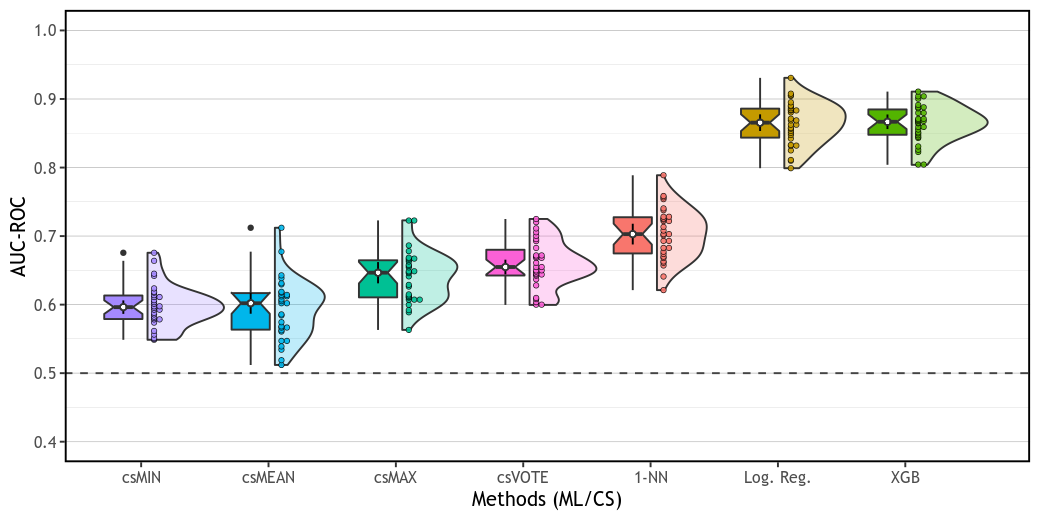

In [50]:
%%R -i full_names -i df_R -w 8 -h 4 --units in -r 130

source('./plotSwarmBox.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- full_names

plot_swarm_box(df_R, cbbPalette, decreasing_order = FALSE, y_min=0.4, y_max=1.)

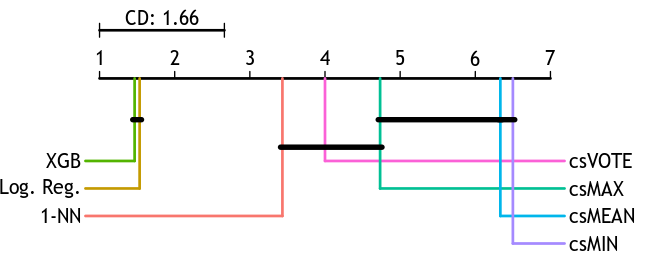

In [17]:
%%R -i df_R -i full_names -w 5 -h 2 --units in -r 130
library(scmamp)

source('./plotCD.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- full_names

par(family = "Trebuchet MS")
plotCD_color(df_R, alpha=0.05, cex=.9, colPalette=cbbPalette)

R[write to console]: PMCMR is superseded by PMCMRplus and will be no longer maintained. You may wish to install PMCMRplus instead.

R[write to console]: 
Attaching package: ‘reshape2’


R[write to console]: The following object is masked from ‘package:tidyr’:

    smiths




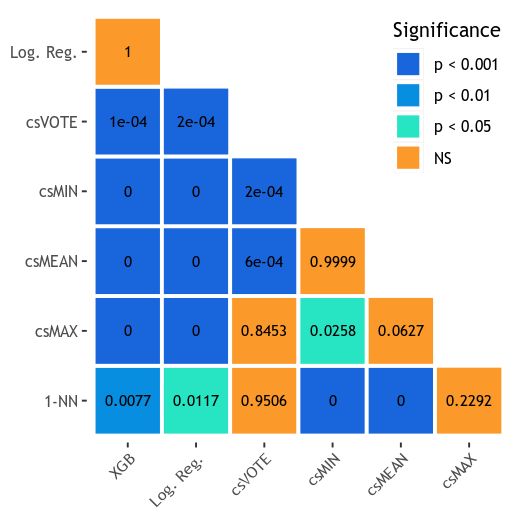

In [18]:
%%R -i df_R -w 4 -h 4 --units in -r 130

source('./plot_p_vals_heatmap.R')

plot_p_vals_heatmap(df_R)

## EF 2%


In [19]:
# ROC-AUC
metric_name='nef_02'

# Normality
display(multi_norm_test(ho30, metric=metric_name))
# Homocedasticity
display(multi_homovar_test(ho30, metric=metric_name))

friedmanTest(ho30.loc[metric_name])

1-NN  Log. Reg.  XGB  csMAX  csMEAN  csMIN  csVOTE
Normality     1          1    1      0       0      0       0

statistic             p
Bartlett  47.380353  1.571149e-08

chi^2  dof       p_value
Friedman Test  151.575    6  3.593616e-30

In [20]:
df_R = order_df(ho30, metric_name).loc[metric_name]
df_Rmelted = pd.melt(df_R, var_name='method', value_name='score')

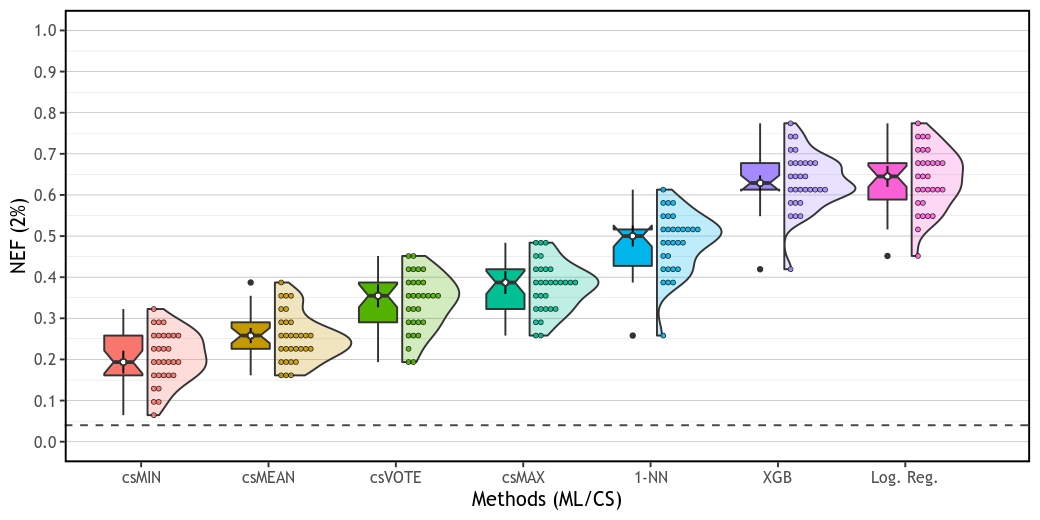

In [35]:
%%R -i df_Rmelted -i df_R -i full_names -w 8 -h 4 --units in -r 130

source('./plotSwarmBox.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- full_names 

plot_swarm_box(df_R, cbbPalette, decreasing_order = FALSE, y_min=0.0, y_max=1.0, 
               y_label='NEF (2%)', dot_size=12, bin_width=0.001, base_h_line=R_a)

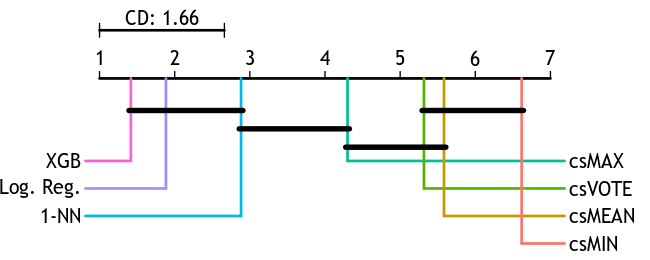

In [22]:
%%R -i df_R -i full_names -w 5 -h 2 --units in -r 130
library(scmamp)

source('./plotCD.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- full_names 

par(family = "Trebuchet MS")
plotCD_color(df_R, alpha=0.05, cex=.9, colPalette=cbbPalette)

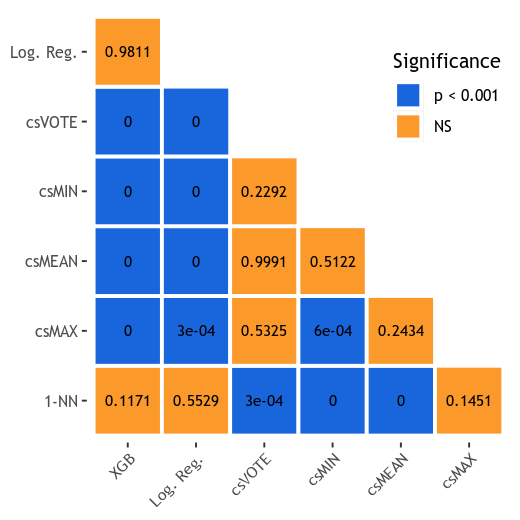

In [23]:
%%R -i df_R -w 4 -h 4 --units in -r 130

source('./plot_p_vals_heatmap.R')

plot_p_vals_heatmap(df_R)

## EF 12%
### Ra = 0.12

In [24]:
# ROC-AUC
metric_name='nef_12_Ra'

# Normality
display(multi_norm_test(ho30, metric=metric_name))
# Homocedasticity
display(multi_homovar_test(ho30, metric=metric_name))

friedmanTest(ho30.loc[metric_name])

1-NN  Log. Reg.  XGB  csMAX  csMEAN  csMIN  csVOTE
Normality     1          1    1      1       1      1       1

statistic         p
Bartlett   2.765023  0.837708

chi^2  dof       p_value
Friedman Test  160.203571    6  5.362081e-32

In [25]:
df_R = order_df(ho30, metric_name).loc[metric_name]
df_Rmelted = pd.melt(df_R, var_name='method', value_name='score')

R[write to console]: notch went outside hinges. Try setting notch=FALSE.

R[write to console]: notch went outside hinges. Try setting notch=FALSE.



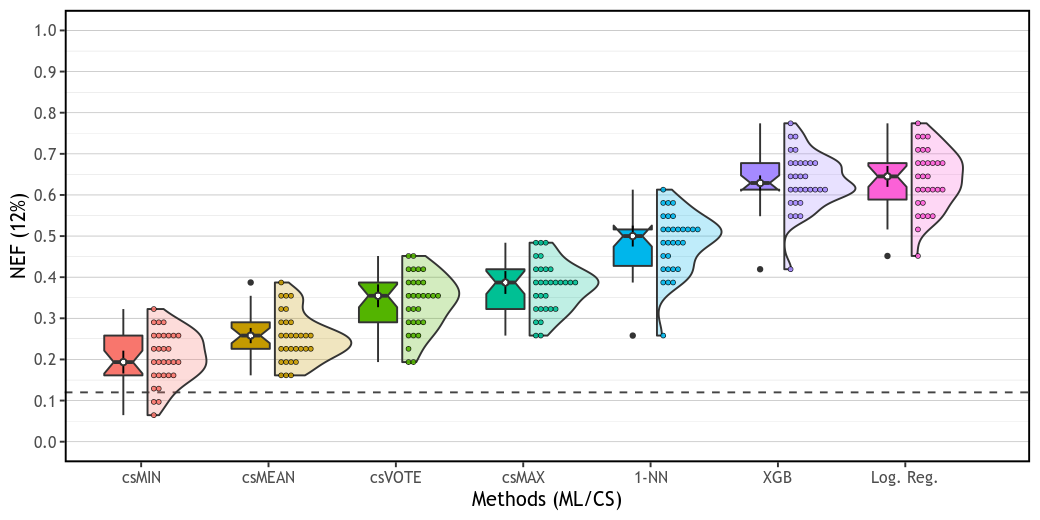

In [26]:
%%R -i df_Rmelted -i df_R -i full_names -w 8 -h 4 --units in -r 130

source('./plotSwarmBox.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- full_names

plot_swarm_box(df_R, cbbPalette, decreasing_order = FALSE, y_min=0.0, y_max=1.0, 
               y_label='NEF (12%)', dot_size=12, bin_width=0.001, base_h_line=R_a)

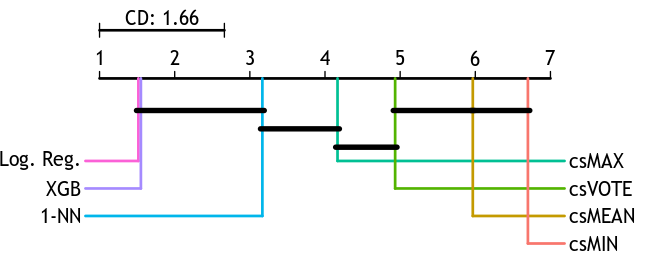

In [27]:
%%R -i df_R -i full_names -w 5 -h 2 --units in -r 130
library(scmamp)

source('./plotCD.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- colnames(df_R)

par(family = "Trebuchet MS")
plotCD_color(df_R, alpha=0.05, cex=.9, colPalette=cbbPalette)

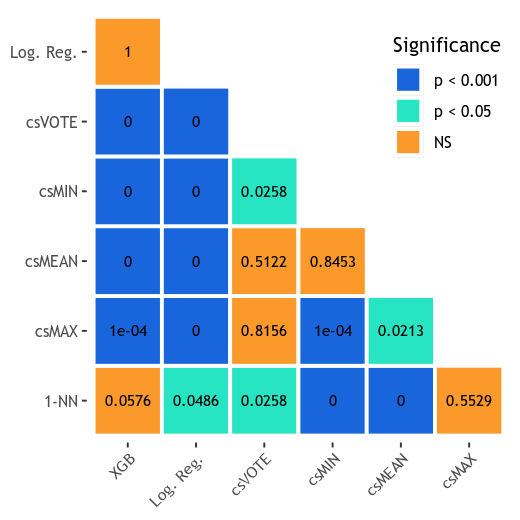

In [28]:
%%R -i df_R -w 4 -h 4 --units in -r 130

source('./plot_p_vals_heatmap.R')

plot_p_vals_heatmap(df_R)

# Y-randomization test

In [29]:
@run_or_load_joblib
def n_hout_val_scrambling(filename, y, random_chi,  **kwargs):
    y_rand = randomize_y_labels(y_target=y, random_chi=random_chi)
    results = n_hold_out_validation(y=y_rand, **kwargs)
    return results

In [30]:
%%time
chi_fractions = [1, 0.75, 0.5, 0.25, 0.0]
n_reps=30
chi_results = {}
evaluation_name = f'y_scrambling_{n_reps}_reps'

for chi in chi_fractions:
    filename = f'./cachedir/{evaluation_name}_{protein_name}_chi-{chi}'
    result = n_hout_val_scrambling(filename=filename, 
                             random_chi=chi, estimators=estimators, 
                             X=X, y=y, metrics=metrics, 
                             n_reps=n_reps, random_state=42)
    print(f'Fraction chi={chi} finished.')
    chi_results[f'chi_{chi}'] = result
    

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/ricci/miniconda3/envs/mds/lib/python3.7/site-packages/IPython/core/magics/execution.py", line 1315, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 11, in <module>
  File "/home/ricci/Documentos/Doctorado/DOCTO_TESIS/Proteinas_Modelo/CDK2/CDK2/ANALISIS/modules/run_or_load_decorator.py", line 34, in wrapper
    obj = func(filename, *args, **kwargs)
  File "<ipython-input-29-0d19af74d2fa>", line 4, in n_hout_val_scrambling
    results = n_hold_out_validation(y=y_rand, **kwargs)
  File "/home/ricci/miniconda3/envs/mds/lib/python3.7/site-packages/joblib/memory.py", line 565, in __call__
    return self._cached_call(args, kwargs)[0]
  File "/home/ricci/miniconda3/envs/mds/lib/python3.7/site-packages/joblib/memory.py", line 531, in _cached_call
    out, metadata = self.call(*args, **kwargs)
  File "/home/ricci/miniconda3/envs/mds/lib/python3.7/site-packages/joblib/memory.py", line 727, in call
    output = self.func(*args, *

TypeError: object of type 'NoneType' has no len()

## AUC-ROC

In [ ]:
df_y_random = get_group_stats(chi_results, metric_name='roc_auc')
df_y_random = df_y_random.replace(new_names)

In [ ]:
%%R -i df_y_random -i df_R -w 9 -h 4 --units in -r 130

source('./plotSwarmBox.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- colnames(df_R)

plot_lines(df_y_random, cbbPalette)

## EF 2% 

In [ ]:
df_y_random = get_group_stats(chi_results, metric_name='nef_02')
df_y_random = df_y_random.replace(new_names)

In [ ]:
%%R -i df_y_random -i df_R -w 9 -h 4 --units in -r 130

source('./plotSwarmBox.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- colnames(df_R)

plot_lines(df_y_random, cbbPalette, y_min=0, base_h_line=R_a, y_label='NEF (2%)')

## EF 12% 

In [ ]:
df_y_random = get_group_stats(chi_results, metric_name='nef_12_Ra')
df_y_random = df_y_random.replace(new_names)

In [ ]:
%%R -i df_y_random -i df_R -w 9 -h 4 --units in -r 130

source('./plotSwarmBox.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- colnames(df_R)

plot_lines(df_y_random, cbbPalette, y_min=0, y_max=1, base_h_line=R_a, y_label='NEF (12%)')